In [20]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [21]:
generator_llm = ChatOpenAI(model='gpt-4o-mini')
evaluator_llm = ChatOpenAI(model='gpt-4o-mini')
optimizer_llm = ChatOpenAI(model='gpt-4o-mini')

In [34]:
# define state

class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]


In [35]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [36]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)


In [37]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [38]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [39]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [40]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement' 

In [41]:
graph = StateGraph(TweetState)

# create nodes
graph.add_node('generate',generate_tweet)
graph.add_node('evalute', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

# create edges
graph.add_edge(START,'generate')
graph.add_edge('generate','evalute')

#conditional Edges
graph.add_conditional_edges('evalute', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize','evalute')

workflow = graph.compile()

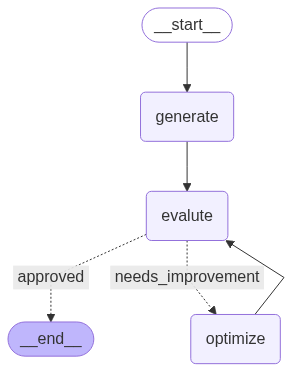

In [42]:
workflow

In [43]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [44]:
result

{'topic': 'srhberhb',
 'tweet': 'Just spent 10 minutes trying to figure out what "srhberhb" means. Turns out it’s just my cat\'s thoughts during our 3 AM philosophical debates about the purpose of life and whether I’ll ever get the laser pointer out of the closet. #DeepThoughts #CatLife',
 'evaluation': 'approved',
 'feedback': "This tweet showcases originality with a unique concept of a cat's philosophical musings, which we haven't seen before in the context of cat thoughts. It incorporates humor effectively, blending an absurd scenario with relatable elements of pet ownership, likely to elicit a smile from readers. While the tweet is slightly lengthy, it still maintains engagement without being overly verbose, and utilizes hashtags that fit the theme, boosting its potential virality. Overall, it’s a well-formed tweet that is unlikely to be auto-rejected.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['Just spent 10 minutes trying to figure out what "srhberhb" means. Turns